<h1><center>Лабораторна робота 5.</center></h1>
<h2><center>Логістична регресія й випадковий ліс в задачі кредитного скорингу</center></h2>

**Виконав:** Прізвище І.П.

**Варіант:** №__

<a class="anchor" id="lab-5"></a>

## Зміст 

- [5.1. Завантаження навчальних даних](#lab-5.1)
- [5.2. Бутстреп](#lab-5.2)  
- [5.3. Підбір параметрів для ансамблевих моделей](#lab-5.3)
- [5.4. Визначення впливу ознак](#lab-5.4)
- [5.5. Створення ансамблевих моделей](#lab-5.5)
- [5.6. Удосконалення ансамблевих моделей](#lab-5.6)

Головним завданням цієї лабораторної роботи є побудова моделі на основі машинного навчання (МН) для задачі кредитного скорингу.

<a class="anchor" id="lab-5.1"></a>

## <span style="color:blue; font-size:1.2em;">5.1. Завантаження навчальних даних</span>

[Повернутися до змісту](#lab-5)

Змінна, значення якої прогнозується, $Y$:

 - SeriousDlqin2yrs – стан невиплати людиною кредиту впроводж наступних 90 днів; можливі значення: 1 – клієнт оплачує кредит із запізненням або не виплачує взагалі, 0 – клієнт оплачує кредит вчасно. 

Незалежні ознаки, $X$:

 - age – вік позичальника кредитних коштів; тип – integer;
 - NumberOfTime30-59DaysPastDueNotWorse – кількість прострочених виплат інших кредитів більше 30-59 днів тому, але не більше впродовж останніх двох років; тип – integer;
 - DebtRatio – відношення щомісячного відрахування щодо заборгованості (кредити, аліменти тощо) до сукупного місячного доходу (percentage); тип – real;
 - MonthlyIncome – місячний дохід в доларах; тип – real;
 - NumberOfTimes90DaysLate – кількість прострочених виплат інших кредитів більше 90 днів; тип – integer;
 - NumberOfTime60-89DaysPastDueNotWorse – кількість прострочених виплат інших кредитів більш 60-89 днів, але не більше впродовж останніх двох років; тип – integer;
 - NumberOfDependents – кількість членів сім'ї позичальника; тип – integer.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Відключимо попередження Anaconda
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

In [2]:
# Задамо графіки у форматі .svg, щоби вони мали кращу чіткість
%config InlineBackend.figure_format = 'svg' 

# Підвищимо розмір графіків за замовчуванням
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 7, 5

Створимо функцію, яка буде замінювати NaN значення на медіану в кожному стовпчику таблиці:

In [3]:
def delete_nan(table):
    for col in table.columns:
        table[col]= table[col].fillna(table[col].median())
    return table   

Завантажуємо дані для подальшого навчання:

In [4]:
credit_scoring_url = 'https://raw.githubusercontent.com/radiukpavlo/intelligent-data-analysis/refs/heads/main/02_assignments/ida_lab-05_logit-rf-credit-scoring/credit_scoring_sample.csv'

data = pd.read_csv(credit_scoring_url, sep =';')
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


Розглянемо типи завантажених даних:

In [5]:
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Переглянемо розподіл класів у цільовій змінні:

Distribution of target


SeriousDlqin2yrs
0    0.777511
1    0.222489
Name: count, dtype: float64

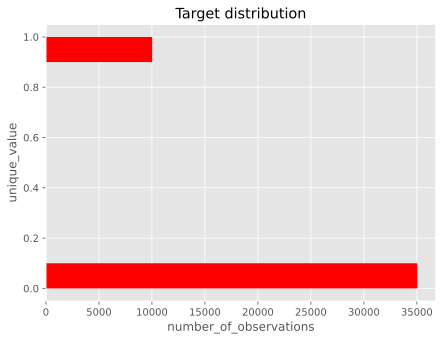

In [6]:
ax = data['SeriousDlqin2yrs'].hist(orientation='horizontal', color='red')
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print('Distribution of target')
data['SeriousDlqin2yrs'].value_counts()/data.shape[0]

Далі виберемо назви всіх ознак з таблиці, крім прогнозованого.

In [7]:
independent_columns_names = data.columns.values
independent_columns_names = [x for x in data if x != 'SeriousDlqin2yrs']
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

Застосовуємо функцію, яка замінює всі NaN значення на медіанне значення відповідного стовпця.

In [8]:
table = delete_nan(data)

Розділяємо підготовлений набір даних на незалежні ознаки ($X$) та цільову ознаку ($y$).

In [9]:
X = table[independent_columns_names]
y = table['SeriousDlqin2yrs']

<a class="anchor" id="lab-5.2"></a>

## <span style="color:blue; font-size:1.2em;">5.2. Бутстреп</span>

[Повернутися до змісту](#lab-5)

Спершу обрахуйте інтервальну оцінку середнього віку (age) для надійних клієнтів та тих клієнтів, що прострочили виплату кредиту з "впевненістю" >= 90% . Використайте приклад з лекції, поставте `np.random.seed (0)`, як це зроблено в огляді.

In [10]:
# Допоміжна функція для генерації підвибірок за допомогою бутстрепу
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

### <span style="color:red; font-size:1.5em;">Завдання 1</span>

У контексті проекту "Бустрем" (моніторингової платформи кредитного портфеля) на основі `credit_scoring_sample.csv` побудуйте серію варіантів. Усі варіанти починаються з розрахунку 90% довірчого інтервалу середнього віку (`age`) для надійних клієнтів (`SeriousDlqin2yrs == 0`) та тих, хто прострочив кредит (`SeriousDlqin2yrs == 1`) з довірчою ймовірністю >= 90% за прикладом з лекції, фіксуючи `np.random.seed(0)` перед кожною вибіркою. Далі "Бустрем" очікує різні підходи до доповнення цих базових оцінок: поглиблена інженерія, візуалізація, підгрупи та комунікація висновків.

---

**Варіант 1 – Базова інтервальна оцінка:**

- Мета: відтворити лекційний приклад і отримати 90% довірчі інтервали віку для обох груп.  
- Кроки:  
  1. Відфільтруйте `SeriousDlqin2yrs` і встановіть `np.random.seed(0)` перед відбором (наприклад, по 500 записів на групу).  
  2. Обчисліть `mean`, `sem` і використайте `stats.t.ppf(0.95, df)` для меж інтервалу.  
  3. Запишіть середні й межі в таблицю.  
- Підказки: `scipy.stats.sem`, `stats.t.ppf`, переконайтеся, що `df = n - 1`.

---

**Варіант 2 – Підтвердження стабільності seed:**

- Мета: показати, що інтервали з `np.random.seed(0)` відтворювані та не змінюються без зміни seed.  
- Кроки:  
  1. Для надійних і дефолтних клієнтів фіксуйте `np.random.seed(0)` і відбирайте 300 записів із `np.random.choice` без заміни.  
  2. Побудуйте 90% інтервали та повторіть ще двічі, щоб побачити, що значення не змінюються.  
  3. Занотуйте, скільки разів межі ідентичні та коли змінився формат даних.  
- Підказки: фіксуйте `np.random.seed(0)` перед кожним `choice`, зберігайте маску й результати.

---

**Варіант 3 – Бутстрепівський інтервал:**

- Мета: отримати 90% інтервал віку через бутстреп, що описує додаткову невизначеність.  
- Кроки:  
  1. За `np.random.seed(0)` згенеруйте 2000 бутстреп-реплік середнього віку для кожної групи (з поверненням).  
  2. Порахуйтe 5-й і 95-й перцентили з масиву `boot_means`.  
  3. Оцініть, наскільки ширші бутстреп-інтервали від класичних.  
- Підказки: використайте `np.random.choice` для індексів та `np.percentile`.

---

**Варіант 4 – Візуалізація інтервалів:**

- Мета: створити графік із 90% інтервалами для кожної групи та пояснити, як "Бустрем" читає його.  
- Кроки:  
  1. З `np.random.seed(0)` виконайте звичайну вибірку, знайдіть інтервали.  
  2. Зобразіть на `matplotlib` або `seaborn` середні з errorbar.  
  3. Додайте пояснення, які вікові межі сигналізують про підвищений контроль.  
- Підказки: `plt.errorbar`, горизонтальні лінії, додавайте текст з `ax.text`.

---

**Варіант 5 – Інтервали за квантилями віку:**

- Мета: представити 90% інтервали як відрізки між 5-м і 95-м перцентилями.  
- Кроки:  
  1. Встановіть seed і збережіть вибірку, знайдіть 5-й та 95-й перцентили для `age`.  
  2. Порівняйте ширину перцентильних інтервалів між групами.  
  3. Додайте опис, чи перцентильний метод дає ті ж висновки.  
- Підказки: `np.percentile`, `pd.Interval`, фіксуйте `n`.

---

**Варіант 6 – Вплив розміру вибірки:**

- Мета: дослідити, як зростання `n` із 200 до 800 впливає на ширину 90% інтервалу.  
- Кроки:  
  1. З `np.random.seed(0)` зробіть вибірки 200, 400, 800 записів для кожної групи.  
  2. Для кожного `n` підрахуйте margin of error і ширину інтервалу.  
  3. Зобразіть залежність ширини від `n`.  
- Підказки: `stats.sem`, `np.sqrt(n)`, запишіть формулу width = 2 * margin.

---

**Варіант 7 – Імовірнісний нагляд "Бустрем":**

- Мета: визначити, які вікові спостереження виходять за межі 90% інтервалів і можуть слугувати тригером.  
- Кроки:  
  1. Отримайте інтервали для обох груп із `np.random.seed(0)` та знайдіть порушників.  
  2. Знайдіть клієнтів, вік яких менший або більший за межі (виведіть кількість).  
  3. Пропишіть умову тригера для "Бустрем".  
- Підказки: `np.where`, `DataFrame.query`, зберігайте `interval_lower`/`upper`.

---

**Варіант 8 – Логарифмічний масштаб віку:**

- Мета: оцінити 90% інтервали після трансформації `np.log(age + 1)` і повернути вік назад.  
- Кроки:  
  1. З `np.random.seed(0)` зчитайте `log_age` та обчисліть інтервали для обох груп.  
  2. Інтервали зворотніх перетворень (exponentiate).  
  3. Порівняйте з класичними інтервалами і напишіть, чому трансформація допомагає.  
- Підказки: `np.log1p`, `np.expm1`, зверніть увагу на зміщення смуги.

---

**Варіант 9 – Інтервали для клієнтів із DebtRatio < 0.3:**

- Мета: розрахувати 90% інтервали віку для груп з низьким борговим навантаженням.  
- Кроки:  
  1. Відфільтруйте за `DebtRatio < 0.3`, застосуйте `np.random.seed(0)` і вибірку.  
  2. Обчисліть середні та інтервали, порівняйте з загальними.  
  3. Додайте коментар, чи "Бустрем" може знижувати контроль для такої категорії.  
- Підказки: `df.query`, `np.percentile`, `df['DebtRatio']`.

---

**Варіант 10 – Утриманці та інтервали:**
  
- Мета: надати 90% інтервали віку для клієнтів з і без утриманців окремо.  
- Кроки:  
  1. Розбийте дані на `NumberOfDependents == 0` та `>= 1` для кожної групи при `np.random.seed(0)`.  
  2. Обчисліть інтервали й порівняйте: де ширше.  
  3. Додайте висновок для "Бустрем" щодо сімейного навантаження.  
- Підказки: `groupby`, `stats.t.ppf`, зберігайте `dependents_group`.

---

**Варіант 11 – Рівні довіри 85%, 90%, 95%:**

- Мета: показати, як розширення довіри змінює інтервал віку.  
- Кроки:  
  1. Для `confidence` у списку `[0.85, 0.9, 0.95]` з `np.random.seed(0)` обчисліть margin.  
  2. Побудуйте таблицю з шириною інтервалу для обох груп.  
  3. Поясніть, який рівень рекомендує "Бустрем" для оперативних рішень.  
- Підказки: `stats.t.ppf((1+conf)/2, df)`, `pd.DataFrame`.

---

**Варіант 12 – Сегментування за віком:**

- Мета: окремо розрахувати 90% інтервали для клієнтів старших/молодших 60 років.  
- Кроки:  
  1. Додайте колонку `age_group = age > 60`, задай seed перед вибіркою.  
  2. Для кожного сегмента та `SeriousDlqin2yrs` знайдіть інтервали.  
  3. Чи відрізняються межі між сегментами, і що це каже "Бустрем".  
- Підказки: `df.assign`, `groupby(['age_group','SeriousDlqin2yrs']).apply(...)`.

---

**Варіант 13 – 100 бутстреп-сценаріїв:**

- Мета: проілюструвати варіацію середнього віку через багатократний бутстреп.  
- Кроки:  
  1. За seed = 0 виконати 100 бутстрепів з `np.random.choice` (з заміною).  
  2. Зберегти 90% інтервали кожного разу та посортувати за шириною.  
  3. Показати, як часто інтервали перекриваються між групами.  
- Підказки: використайте `np.random.seed(0)` лише на початку, а далі для відтворення можна зберегти `np.random.RandomState`.

---

**Варіант 14 – Аналітика старших дефолтерів:**

- Мета: знайти 5 найстарших дефолтерів і перевірити, чи вкладаються вони в 90% інтервал.  
- Кроки:  
  1. З `np.random.seed(0)` відберіть інтервали, знайдіть `nlargest(5)` за `age`.  
  2. Порівняйте їхній вік із межами інтервалу, помітні аномалії.  
  3. Підготуйте замітку для "Бустрем": які старші клієнти викликають підозру.  
- Підказки: `nlargest`, `interval_lower/upper`.

---

**Варіант 15 – Інтервали для клієнтів з доходом понад медіану:**

- Мета: оцінити 90% інтервал віку для клієнтів з доходом > median у кожній групі.  
- Кроки:  
  1. При `np.random.seed(0)` відфільтруйте записі з високим доходом.  
  2. Обчисліть інтервали, порівняйте з загальною вибіркою.  
  3. Запропонуйте, чи "Бустрем" може вважати таких клієнтів більш надійними.  
- Підказки: `df['MonthlyIncome'].median()`, `mask`, `stats.t.ppf`.

---

**Варіант 16 – Сезонність і інтервали:**

- Мета: подивитися, чи клієнти, які звертаються в першій половині року, мають відмінні 90% інтервали віку.  
- Кроки:  
  1. З `np.random.seed(0)` додайте колонку `month = np.random.randint(1, 13, size=len(df))`.  
  2. Побудуйте інтервали для `month <= 6` та `>= 7` по обох групах.  
  3. Опишіть, як "Бустрем" може реагувати на сезонні дисбаланси.  
- Підказки: `np.random.randint`, `groupby`, `np.random.seed`.

---

**Варіант 17 – Інтервали за біном DebtRatio:**

- Мета: для кожного біну `DebtRatio` ([0,0.3), [0.3,0.6), [0.6,2]) розрахувати 90% інтервали віку.  
- Кроки:  
  1. Створіть `debt_bin = pd.cut(DebtRatio, bins=[-0.01,0.3,0.6,2], labels=['low','medium','high'])`.  
  2. Для кожного біна і `SeriousDlqin2yrs` з `np.random.seed(0)` обчисліть інтервали.  
  3. Поясніть, як "Бустрем" може використовувати ці розбивки для рівнів контролю.  
- Підказки: `groupby`, `agg`, `stats.t.ppf`.

---

**Варіант 18 – Інтервали на тестовій частині:**

- Мета: розділити дані на `train/test`, побудувати 90% інтервали віку саме на `test`.  
- Кроки:  
  1. `train_test_split` (70/30) зі `stratify`, `random_state=0`.  
  2. На test-set для обох груп з `np.random.seed(0)` розрахуйте інтервали.  
  3. Порівняйте з інтервалами train і повідомте, чи вони стабільні.  
- Підказки: `train_test_split`, `stratify=y`, `np.random.seed(0)` перед `sample`.

---

**Варіант 19 – Інтервали для DebtRatio > 1:**

- Мета: оцінити, чи клієнти з високим `DebtRatio` мають ширші 90% інтервали віку.  
- Кроки:  
  1. Відфільтруйте на `DebtRatio > 1` і, встановивши `np.random.seed(0)`, зробіть вибірку.  
  2. Обчисліть інтервали для надійних/дефолтних клієнтів.  
  3. Подайте висновки для "Бустрем": чи потрібно посилити контроль.  
- Підказки: `df.loc`, `np.random.choice`, `stats.sem`.

---

**Варіант 20 – Комунікація висновків:**

- Мета: сформулювати короткий бриф для "Бустрем" зі 90% інтервалами і практичними рекомендаціями.  
- Кроки:  
  1. Отримайте інтервали за допомогою `np.random.seed(0)`.  
  2. Складіть таблицю (mean, lower, upper, ширина) для обох груп.  
  3. Додайте три ключові рекомендації: кого додатково перевіряти, кого залишити.  
- Підказки: `pd.DataFrame`, `np.random.seed`, вказуйте `n` і `confidence`.

<a class="anchor" id="lab-5.3"></a>

## <span style="color:blue; font-size:1.2em;">5.3. Підбір параметрів для ансамблевих моделей</span>

[Повернутися до змісту](#lab-5)

Однією з важливих метрик якості моделі є значення площі під [ROC-кривої](https://uk.wikipedia.org/wiki/ROC-%D0%BA%D1%80%D0%B8%D0%B2%D0%B0) (AUC). Значення ROC-AUC лежить від 0 до 1. Чим ближче значення метрики ROC-AUC до 1, тим якісніше відбувається класифікація моделлю.

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

Використовуємо модуль [`LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) для побудови логістичної регресії. Через незбалансованість класів в цільовій функції додаємо параметр балансування. Також додамо параметр `random_state=5` для відтворюваності результатів.

In [12]:
lr = LogisticRegression(random_state=5, class_weight= 'balanced')

Тепер спробуємо підібрати найкращий коефіцієнт регуляризації (коефіцієнт C в логістичній регресії) для моделі логістичної регрессії. Найкраще значення параметра С забезпечить нам оптимальність моделі, яка буде добре прогнозувати значення цільової функції і водночас не буде перенавчатися. Інші параметри залишаємо за замовчуванням.

In [13]:
parameters = {'C': (0.0001, 0.001, 0.01, 0.1, 1, 10)}

Щоби підібрати коефіцієнт регуляризації переглянемо значення `ROC-AUC` на Stratified крос-валідації з 5 фолдів для кожного можливого значення коефіцієнта регуляризації за допомогою класу [StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html).

In [14]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

Далі для розв'язку наступного завдання використайте [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) з метрикою `ROC-AUC` за параметром C.

### <span style="color:red; font-size:1.5em;">Завдання 2</span>

---

**Варіант 1 – глибина дерев у бэггінгу:**  
- Мета: знайти значення max_depth для базових дерев, яке забезпечує найкращий баланс між відтворюваністю та якістю виявлення ризикованих позичальників на credit_scoring_sample.csv.  
- Кроки:  
  1. Завантажте таблицю, замініть пропущені MonthlyIncome на медіану, відберіть числові ознаки (age, DebtRatio, MonthlyIncome, NumberOfTimes90DaysLate, NumberOfDependents, NumberOfTime30-59DaysPastDueNotWorse, NumberOfTime60-89DaysPastDueNotWorse).  
  2. Оцініть базову LogisticRegression(random_state=5, class_weight='balanced') через StratifiedKFold(n_splits=5, shuffle=True, random_state=5) і зафіксуйте ROC-AUC.  
  3. Створіть BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=5), n_estimators=100, bootstrap=True, max_samples=0.8) і застосуйте GridSearchCV зі scoring='roc_auc' для значень max_depth = [3, 5, 7, 9, 12].  
  4. Побудуйте графік середнього ROC-AUC від глибини дерева та порівняйте з базовою логістичною регресією.  
- Підказки: скористайтеся `np.median` для імпутації, `StratifiedKFold` гарантує баланс класів, а `classification_report` запропонує додаткову перевірку на `test_size=0.2`.  
- Порівняння з логістичною регресією: покажіть, чи Bagging з оптимальною глибиною підвищує ROC-AUC, і поясніть вплив max_depth.  

---

**Варіант 2 – кількість дерев у бэггінгу:**  
- Мета: виявити, скільки базових дерев (`n_estimators`) потрібно для стабільної ROC-AUC, враховуючи `credit_scoring_sample.csv` і незначний дисбаланс.  
- Кроки:  
  1. Підготуйте ознаки та цільову змінну, замість `MonthlyIncome` використайте стандартизований залишок `MonthlyIncome / age`.  
  2. Збережіть результати ROC-AUC з базової логістичної регресії та використайте `StratifiedKFold`.  
  3. Візьміть `BaggingClassifier` із `DecisionTreeClassifier(max_depth=6, random_state=5)` і запустіть `GridSearchCV` на `n_estimators = [50, 100, 200, 400]` при `max_samples=0.75`.  
  4. Оцініть швидкість навчання й дисперсію крос-валідації, виберіть найкращий `n_estimators`.  
- Підказки: `GridSearchCV` з `return_train_score=True` дозволить побачити перенавчання, а `np.log1p(DebtRatio)` зменшить вплив великих значень.  
- Порівняння з логістичною регресією: покажіть, чи додаткові дерева дають ефект у ROC-AUC і наскільки довше обчислення.  

---

**Варіант 3 – мінімальна кількість зразків для поділу:**  
- Мета: налаштувати min_samples_split, щоб уникнути глибоких дефектних вузлів, створивши додаткові ознаки, які описують історію прострочень.  
- Кроки:  
  1. Сформуйте ознаку payment_history = NumberOfTimes90DaysLate + NumberOfTime30-59DaysPastDueNotWorse, нормалізуйте її через MinMaxScaler на рівні (0, 1), а також додайте individual_debt_ratio = DebtRatio / (NumberOfDependents + 1).  
  2. Програйте LogisticRegression(random_state=5, class_weight='balanced') як базову модель, збережіть метрику `roc_auc_score` на `StratifiedKFold(n_splits=5)`.  
  3. Побудуйте BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=5), n_estimators=120, bootstrap=True) і в GridSearchCV перевірте min_samples_split у [2, 4, 6, 8, 10].  
  4. Проаналізуйте, чи зростання min_samples_split зменшує варіанс та наскільки це співвідноситься із новою ознакою payment_history.  
- Підказки: використайте Pipeline або окрему трансформацію, щоб MinMaxScaler не зашумлював решту ознак, а scoring='roc_auc' дозволить зберегти фокус на якості класифікації.  
- Порівняння з логістичною регресією: покажіть, як зміна min_samples_split впливає на ROC-AUC порівняно з базовим алгоритмом.  

---

**Варіант 4 – кількість ознак в кожному дереві:**  
- Мета: підібрати max_features, щоб кожне дерево бачило достатньо, але не надто багато ознак, у моделі на credit_scoring_sample.csv.  
- Кроки:  
  1. Підготуйте набір стандартних ознак, включно зі скольованим DebtRatio, MonthlyIncome та агрегатами NumberOfTime60-89DaysPastDueNotWorse і NumberOfTimes90DaysLate.  
  2. Оцініть LogisticRegression(random_state=5, class_weight='balanced') як опорну лінію.  
  3. Побудуйте BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=8, random_state=5), bootstrap=True, n_estimators=150) і застосуйте GridSearchCV для max_features = ['sqrt', 'log2', 0.5, 0.75, 1.0].  
  4. Візуалізуйте ROC-AUC щодо max_features і виберіть найстабільніший варіант.  
- Підказки: поєднуйте шукач з `StratifiedKFold`, використовуйте `ColumnTransformer` для числового скейлінгу, а `return_train_score=True` допоможе помітити перенавчання.  
- Порівняння з логістичною регресією: опишіть, чи зменшення max_features підвищує узагальнення порівняно з одиночним логістичним класифікатором.  

---

**Варіант 5 – випадкова вибірка ознак:**  
- Мета: визначити, як вмикання/вимикання bootstrap_features змінює якість ансамблю при роботі з дисбалансною вибіркою.  
- Кроки:  
  1. Зберіть ознаки, додайте логарифм `np.log1p(MonthlyIncome)` та `DebtRatio`, а пропуски заповніть медіаною.  
  2. Зафіксуйте LogisticRegression(random_state=5, class_weight='balanced') як референс.  
  3. Ініціалізуйте BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=7, random_state=5), n_estimators=120, max_samples=0.8) і проведіть GridSearchCV по bootstrap_features = [True, False] і max_features = [0.5, 0.7, 'sqrt'].  
  4. Порівняйте ROC-AUC, precision, `recall` та оцініть, наскільки часто bootstrap_features=True допомагає уникнути однотипних дерев.  
- Підказки: bootstrap_features контролює, чи змінюються ознаки для кожного дерева, тому поєднання з різними max_features дає інсайти щодо «сирої» або «збалансованої» інформації.  
- Порівняння з логістичною регресією: наочно покажіть, в яких ділянках простору ознак bootstrap_features=True дає перевагу.  

---

**Варіант 6 – частка вибірки для кожного дерева:**  
- Мета: підібрати max_samples, щоб баланс між різноманітністю та інформацією про кредитну історію давав найвищий ROC-AUC.  
- Кроки:  
  1. Завантажте дані, заповніть MonthlyIncome медіаною та додайте credit_age = age / (NumberOfDependents + 1) як нову ознаку.  
  2. Засвойте базовий LogisticRegression(random_state=5, class_weight='balanced') і порівняйте ROC-AUC.  
  3. Візьміть BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=7, random_state=5), n_estimators=200, bootstrap=True) та проведіть GridSearchCV з max_samples = [0.4, 0.6, 0.8, 1.0] при max_features=0.7.  
  4. Оцініть, чи обмеження вибірки призводить до стабільнішої оцінки ROC-AUC, і порівняйте з результатами логістичної регресії.  
- Підказки: max_samples можна вказати як частку (`float`) або абсолютну кількість; зберігайте однаковий `random_state` для реплікованості.  
- Порівняння з логістичною регресією: як зміна max_samples впливає на розрив між Bagging та логістичною моделлю?  

---

**Варіант 7 – оцінка позавибірковими зразками:**  
- Мета: використати oob_score=True, щоб підібрати max_depth і порівнювати оцінку з ROC-AUC на крос-валідації.  
- Кроки:  
  1. Підготуйте дані, імпутуйте MonthlyIncome, а DebtRatio розбийте на квантилі за допомогою pd.qcut.  
  2. Змоделюйте LogisticRegression(random_state=5, class_weight='balanced'), зареєструйте середній ROC-AUC.  
  3. Створіть BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=5), n_estimators=150, bootstrap=True, oob_score=True) і за допомогою GridSearchCV переберіть max_depth = [5, 7, 9, 11].  
  4. Для кожного значення проаналізуйте oob_score_ та cv_results_['mean_test_score'], поясніть розбіжності.  
- Підказки: oob_score за умов bootstrap=True надає «безкоштовну» оцінку, але її варто порівнювати з StratifiedKFold.  
- Порівняння з логістичною регресією: покажіть, чи oob_score дає стимул до кращого ROC-AUC порівняно з логістичною межею.  

---

**Варіант 8 – кількість зразків у листі:**  
- Мета: обмежити min_samples_leaf, щоб запобігти надто дрібним листам і одночасно зберегти знання про клієнтів із високим DebtRatio.  
- Кроки:  
  1. Додайте ознаки DebtRatio_log = np.log1p(DebtRatio) і late_payments = NumberOfTimes90DaysLate + NumberOfTime60-89DaysPastDueNotWorse, заповніть пропуски MonthlyIncome.  
  2. Порівняйте ROC-AUC базової LogisticRegression(random_state=5, class_weight='balanced') із первинною метрикою.  
  3. Встановіть BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=5), n_estimators=140, bootstrap=True) та проведіть GridSearchCV з min_samples_leaf = [1, 3, 5, 7, 10] і max_depth=9.  
  4. Продемонструйте, як min_samples_leaf впливає на кількість листових кінців та ROC-AUC.  
- Підказки: для візуалізації скористайтесь pd.Series(grid.cv_results_['mean_test_score'], index=grid.param_grid['min_samples_leaf']), а std_test_score підкаже про стабільність.  
- Порівняння з логістичною регресією: поясніть різницю в перевагах між регуляризацією в логістиці та контрольованим листом у деревах.  

---

**Варіант 9 – вибір критерію поділу:**  
- Мета: з'ясувати, який критерій (gini або entropy) краще показує ризик дефолту, та чи варто поєднати це з min_samples_split.  
- Кроки:  
  1. Сформуйте ознаки, додайте late_rate = NumberOfTimes90DaysLate / (age + 1) і 
p.log1p(DebtRatio), імпутуйте MonthlyIncome.  
  2. Отримайте базовий ROC-AUC від LogisticRegression(random_state=5, class_weight='balanced').  
  3. Ініціалізуйте BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=5), n_estimators=130, bootstrap=True) та при GridSearchCV(scoring='roc_auc') переберіть base_estimator__criterion = ['gini', 'entropy'] та base_estimator__min_samples_split = [2, 4, 6].  
  4. Проаналізуйте, чи entropy скорочує сумарну невизначеність більше, ніж gini, і як це впливає на ROC-AUC.  
- Підказки: BaggingClassifier передає параметри базовому естиматору через base_estimator__, тож саме так формуються param_grid.  
- Порівняння з логістичною регресією: порівняйте, наскільки зміна критерію підсилює перевагу ансамблю над логістикою.  

---

**Варіант 10 – випадковий пошук глибини та кількості дерев:**  
- Мета: вирішити, чи швидкий RandomizedSearchCV дає порівнянні або кращі результати, ніж повний перебір, підбираючи одночасно 
_estimators і max_depth.  
- Кроки:  
  1. Завантажте дані, імпутуйте MonthlyIncome, відкиньте NumberOfDependents із NaN, а DebtRatio зробіть 
p.log1p.  
  2. Оцініть базову LogisticRegression(random_state=5, class_weight='balanced') за 
oc_auc_score.  
  3. Ініціалізуйте BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=5), bootstrap=True) і запустіть RandomizedSearchCV (n_iter=20, cv=StratifiedKFold(5)) для max_depth у [3, 5, 7, 9, 11, 13] та 
_estimators у [50, 100, 150, 200, 250, 300].  
  4. Порівняйте best_score_ з базовою логістичною регресією та зафіксуйте час пошуку.  
- Підказки: встановіть 
p.random.seed(5) перед RandomizedSearchCV, а також 
eturn_train_score=True, щоби бачити розрив між навчанням і валідацією.  
- Порівняння з логістичною регресією: прикріпіть ROC-AUC від обох моделей та прокоментуйте, чи випадковий пошук обійшов детермінований перебір.  

---

**Варіант 11 – пайплайн із масштабуванням та поліномами:**  
- Мета: додати трансформації до ознак (MonthlyIncome, DebtRatio) перед ансамблем та підібрати одночасно degree у PolynomialFeatures і max_depth дерев.  
- Кроки:  
  1. Створіть ColumnTransformer, який масштабує числові ознаки через StandardScaler, а до DebtRatio і MonthlyIncome додає PolynomialFeatures(include_bias=False).  
  2. Порівняйте з базовою LogisticRegression(random_state=5, class_weight='balanced') для контрольної точки ROC-AUC.  
  3. Вбудуйте BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=5), bootstrap=True) в Pipeline і застосуйте GridSearchCV з параметрами polynomial__degree = [1, 2] і bagging__max_depth = [5, 7, 9].  
  4. Проаналізуйте, як підвищення degree змінює ROC-AUC та порівняйте час навчання з логістичною регресією.  
- Підказки: використовуйте префікси pipeline.set_params(polynomial__degree=...) у GridSearchCV, StratifiedKFold гарантує стабільну оцінку, а Pipeline захищає від витоку даних.  
- Порівняння з логістичною регресією: чи трансформація ознак додає ефект порівняно з простою логістичною регресією?  

---

**Варіант 12 – обмеження кількості листових вузлів:**  
- Мета: підібрати max_leaf_nodes для DecisionTreeClassifier у складі BaggingClassifier, щоби уникнути дуже розгалужених дерев.  
- Кроки:  
  1. Створіть ознаки Debt_per_dependant = DebtRatio / (NumberOfDependents + 1) та income_per_age = MonthlyIncome / (age + 1), імпутуйте MonthlyIncome.  
  2. Зафіксуйте ROC-AUC базової LogisticRegression(random_state=5, class_weight='balanced').  
  3. Запустіть GridSearchCV(scoring='roc_auc') для BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=5), bootstrap=True, n_estimators=150) із max_leaf_nodes = [10, 20, 40, 80, 160, None].  
  4. Порівняйте mean_test_score для кожного max_leaf_nodes і опишіть, де модель стає стабільною.  
- Підказки: max_leaf_nodes=None дозволяє дереву розростатися, тому у GridSearchCV слід подивитися на сумісний std_test_score.  
- Порівняння з логістичною регресією: розкажіть, де контроль кількості листів дає перевагу над регуляризацією логістичного оцінювання.  

---

**Варіант 13 – стабільність випадковості:**  
- Мета: підібрати 
andom_state, який забезпечує стабільний ROC-AUC, водночас налаштувавши 
_estimators.  
- Кроки:  
  1. Підготуйте базу ознак, імпутуючи MonthlyIncome, і зафіксуйте LogisticRegression(random_state=5, class_weight='balanced').  
  2. Запустіть GridSearchCV над BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=8), bootstrap=True, n_estimators=150) із параметрами 
andom_state = [0, 5, 42, 99] та 
_estimators = [100, 150, 200], scoring='roc_auc'.  
  3. Додатково проведіть повтори cross_val_score для найкращої комбінації з різними 
andom_state, щоби оцінити розкид.  
  4. Оцініть, чи більш стабільна модель із певним 
andom_state має меншу дисперсію, ніж логістична регресія.  
- Підказки: grid.best_params_ допоможе відтворити найкращий 
andom_state, а 
p.random.seed гарантує, що ви порівнюєте однакові інтерпретації.  
- Порівняння з логістичною регресією: покажіть, яка модель менше реагує на зміну 
andom_state.  

---

**Варіант 14 – поступове додавання дерев через warm_start:**  
- Мета: використати warm_start=True, щоби поетапно додавати дерева й знайти момент стабілізації ROC-AUC.  
- Кроки:  
  1. Підготуйте дані, імпутуйте пропуски, масштабовуйте MonthlyIncome та DebtRatio.  
  2. Ініціалізуйте BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=8, random_state=5), bootstrap=True, warm_start=True) і прописуйте цикл, де кожна ітерація додає по 20 дерев (
_estimators += 20).  
  3. Після кожного кроку вимірюйте ROC-AUC на StratifiedKFold(n_splits=5) і порівняйте з LogisticRegression(random_state=5, class_weight='balanced').  
  4. Змоніторте точку насичення (коли додавання дерев дає <0.005 приросту) та збережіть найкращу конфігурацію.  
- Підказки: warm_start дозволяє не навчати заново всі дерева, але пам'ятайте про oob_score=False, інакше доведеться перезапускати.  
- Порівняння з логістичною регресією: опишіть, чи поступовий додавання дерев прямує до ROC-AUC, близького чи кращого за логістичну модель.  

---

**Варіант 15 – зразки з повторенням або без:**  
- Мета: порівняти bootstrap=True та False, а також підібрати max_samples, аби зрозуміти, чи заміна зразків допомагає боротися з дисбалансом.  
- Кроки:  
  1. Створіть ознаки has_dependents = (NumberOfDependents > 0).astype(int) і debt_to_income = DebtRatio * 100, імпутуйте MonthlyIncome.  
  2. Порахуйте ROC-AUC для LogisticRegression(random_state=5, class_weight='balanced').  
  3. Встановіть BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=5), n_estimators=150) і в GridSearchCV переберіть bootstrap = [True, False] разом із max_samples = [0.6, 0.8, 1.0].  
  4. Поясніть, чи відмова від повторної вибірки дає вищу чи нижчу дисперсію, порівняно з логістичною регресією.  
- Підказки: коли bootstrap=False, max_samples має бути 1.0 або відкидати, натомість bootstrap=True дозволяє зменшити вплив екстремальних записів.  
- Порівняння з логістичною регресією: хто краще справляється з новими складними зразками – Bagging із bootstrap=True чи логістична модель?  

---

**Варіант 16 – мінімальна фракція ваги в листі:**  
- Мета: настроїти min_weight_fraction_leaf, щоб врахувати, що клієнти з вищими доходами мають більший внесок у загальний ризик.  
- Кроки:  
  1. Підготуйте sample_weight = np.where(MonthlyIncome.isna(), 0.5, 1.0) і доповніть її ознакою income_bucket = pd.qcut(MonthlyIncome.fillna(MonthlyIncome.median()), 4, labels=False).  
  2. Перевірте LogisticRegression з class_weight='balanced' як базу.  
  3. Вбудуйте BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=5), n_estimators=150, bootstrap=True) і здійсніть GridSearchCV з min_weight_fraction_leaf = [0.0, 0.01, 0.02, 0.05], передаючи sample_weight у it.  
  4. Порівняйте ROC-AUC при різних фракціях, опишіть, як це впливає на клієнтів із низьким і високим доходом.  
- Підказки: min_weight_fraction_leaf потрібен, коли приклади мають неоднакову важливість; передавайте sample_weight до it, щоби DecisionTreeClassifier зміг використати їх.  
- Порівняння з логістичною регресією: покажіть, чи градаційне відсіювання листів дає кращу якість, ніж class_weight='balanced'.  

---

**Варіант 17 – мінімальне зменшення варіабельності:**  
- Мета: налаштувати min_impurity_decrease, щоб дерево розгалужувалося лише тоді, коли спостерігається достатній приріст інформації.  
- Кроки:  
  1. Створіть нові ознаки late_ratio = NumberOfTimes90DaysLate / (NumberOfTime30-59DaysPastDueNotWorse + 1) та income_to_debt = MonthlyIncome / (DebtRatio + 0.01).  
  2. Оцініть LogisticRegression(random_state=5, class_weight='balanced') з 
oc_auc_score.  
  3. Застосуйте GridSearchCV до BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=5), n_estimators=140, bootstrap=True) для min_impurity_decrease = [0.0, 0.0001, 0.0005, 0.001, 0.005].  
  4. Відстежте, як зростання min_impurity_decrease змінює mean_test_score, і поясніть, чи модель починає пропускати важливі розбивки.  
- Підказки: min_impurity_decrease пропорційно зменшує різницю між перед і після розбиття; GridSearchCV покаже, де ROC-AUC найвищий без надмірного розгалуження.  
- Порівняння з логістичною регресією: порівняйте, наскільки min_impurity_decrease знижує варіацію порівняно з лінійною моделлю.  

---

**Варіант 18 – баггінг логістичних регресій:**  
- Мета: обкатати BaggingClassifier із base_estimator=LogisticRegression і підібрати параметри регуляризації (C) одночасно з 
_estimators.  
- Кроки:  
  1. Підготуйте дані зі стандартизованими MonthlyIncome та DebtRatio, замініть NaN усіх числових ознак на медіану і додайте has_dependents.  
  2. Виміряйте ROC-AUC для одиночної LogisticRegression(random_state=5, class_weight='balanced') із C=1.0.  
  3. Ініціалізуйте BaggingClassifier(base_estimator=LogisticRegression(random_state=5, solver='lbfgs', max_iter=200), bootstrap=True) і проведіть GridSearchCV для 
_estimators = [50, 100, 150] та base_estimator__C = [0.01, 0.1, 1, 10].  
  4. Порівняйте результати з базовою логістичною моделлю та з’ясуйте, чи ансамбль з ремодульованою регуляризацією дає вищий ROC-AUC.  
- Підказки: BaggingClassifier передає параметри до base_estimator через префікс base_estimator__, а sample_weight можна зберігати, щоб врахувати вклад високодохідних клієнтів.  
- Порівняння з логістичною регресією: покажіть, як ансамбль логістичних регресій змінив ROC-AUC та precision, і чим це відрізняється від одиночної моделі.  

---

**Варіант 19 – стекінг баггінгів та логістики:**  
- Мета: побудувати StackingClassifier, де рівень-0 складається з двох налаштованих BaggingClassifier, а мета-естиматор — LogisticRegression, і підібрати ваги/параметри для базових моделей.  
- Кроки:  
  1. Підготуйте дані із заповненням пропусків, стандартним скейлінгом та додатковою ознакою debt_income_ratio.  
  2. Побудуйте два базових BaggingClassifier: перший із max_depth=6, другий із max_features=0.6, обидва з 
_estimators=100.  
  3. Ініціалізуйте StackingClassifier(estimators=[('bag1', bag1), ('bag2', bag2)], final_estimator=LogisticRegression(class_weight='balanced')) і застосуйте GridSearchCV до параметрів bag1__n_estimators, bag2__max_depth та inal_estimator__C.  
  4. Порівняйте ROC-AUC стеку з окремими BaggingClassifier та базовою логістичною моделлю.  
- Підказки: використайте passthrough=True, щоби логістика бачила вихідні ознаки, а cv=StratifiedKFold(5) з shuffle=True гарантує стабільність.  
- Порівняння з логістичною регресією: поясніть, наскільки стек покращив метрику порівняно з одиночним логістичним мета-естиматором.  

---

**Варіант 20 – багатокритерійна оптимізація:**  
- Мета: одночасно контролювати ROC-AUC та Recall через GridSearchCV з декількома скорінгами і підібрати max_depth та max_samples.  
- Кроки:  
  1. Підготуйте ознаки, імпутуючи MonthlyIncome та NumberOfDependents, а також додайте 
ecent_miss_rate = NumberOfTime30-59DaysPastDueNotWorse / (age + 1).  
  2. Виміряйте ROC-AUC для базової LogisticRegression(random_state=5, class_weight='balanced').  
  3. Налаштуйте BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=5), n_estimators=150, bootstrap=True) і проведіть GridSearchCV із scoring={'roc_auc':'roc_auc', 'recall':'recall'}, refit='roc_auc' для max_depth=[5,7,9] та max_samples=[0.6,0.8,1.0].  
  4. Проаналізуйте trade-off між 
oc_auc та 
ecall, поясніть, чому 
efit='roc_auc' залишає Recall другим критерієм у звіті.  
- Підказки: grid.cv_results_ містить окремі метрики (mean_test_recall, mean_test_roc_auc), їх можна відобразити графічно.  
- Порівняння з логістичною регресією: покажіть, чи Bagging дозволяє підвищити Recall, не жертвуючи ROC-AUC.  

<a class="anchor" id="lab-5.4"></a>

## <span style="color:blue; font-size:1.2em;">5.4. Визначення впливу ознак</span>

[Повернутися до змісту](#lab-5)

У цьому завданні ми попрацюємо з важливістю ознак. Пам'ятаємо, що важливість ознаки визначається **абсолютним значенням її коефіцієнта**. Крім того, потрібно заздалегідь нормалізувати всі ознаки, щоб їх правильно порівняти.

In [15]:
from sklearn.preprocessing import StandardScaler

lr = LogisticRegression(C=0.001,random_state=5, class_weight='balanced')
scal = StandardScaler()
lr.fit(scal.fit_transform(X), y)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,0.001
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,5
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


Обрахуємо важливість ознак:

In [16]:
pd.DataFrame({'feat': independent_columns_names,
              'coef': lr.coef_.flatten().tolist()}).sort_values(by='coef', ascending=False)

,feat,coef
1,NumberOfTime30-59DaysPastDueNotWorse,0.723421
3,NumberOfTimes90DaysLate,0.516656
4,NumberOfTime60-89DaysPastDueNotWorse,0.195486
6,NumberOfDependents,0.101722
2,DebtRatio,-0.024068
5,MonthlyIncome,-0.163015
0,age,-0.417115


### <span style="color:red; font-size:1.5em;">Завдання 3</span>

---

**Варіант 1 – Еластичність логіт-коефіцієнтів за віком і DebtRatio:**  
- Мета: порівняти, наскільки чутливо змінюються шанси прострочення при модифікації `age` та `DebtRatio` у стандартизованій логістичній регресії.  
- Кроки:  
  1. Очистіть `credit_scoring_sample.csv`, замініть пропуски медіанами та стандартизуйте числові стовпці.  
  2. Навчіть `LogisticRegression(penalty='none', class_weight='balanced')`, зафіксуйте коефіцієнти та довірчі інтервали через бутстреп ≥1000 ітерацій.  
  3. Обчисліть еластичність `∂logit/∂feature × feature/odds` для `age` та `DebtRatio` у всій вибірці й окремо для клієнтів із `MonthlyIncome` нижче та вище медіани.  
- Підказки: `StandardScaler`, `sklearn.utils.resample`, логіт = log(p/(1-p)). Візуалізуйте еластичності бокс-плотами.  
- Інтерпретація: поясніть, який вік/рівень боргу дає найбільший приріст odds прострочення та чому.

---

**Варіант 2 – SHAP-карти взаємодій RandomForest:**  
- Мета: дослідити спільний вплив `MonthlyIncome` та `NumberOfTimes90DaysLate` у моделі `RandomForestClassifier`.  
- Кроки:  
  1. Збалансуйте вибірку SMOTE або undersampling’ом, навчіть `RandomForestClassifier(n_estimators=500, max_depth=None, random_state=42)`.  
  2. Обчисліть `TreeExplainer` SHAP-значення й побудуйте interaction plot для двох ознак.  
  3. Розбийте клієнтів на квартилі доходу та опишіть, як взаємодія з частотою 90-day late змінює прогноз усередині кожного сегмента.  
- Підказки: `shap.dependence_plot(feature, shap_values, X, interaction_index=...)`. Перед обчисленням SHAP усуньте корельовані змінні (>0.85).  
- Перевірка: переконайтеся, що глобальна важливість SHAP узгоджується з `feature_importances_` (кореляція >0.7).

---

**Варіант 3 – Перестановочна важливість зі стабільністю:**  
- Мета: виміряти, наскільки стабільний вплив ознак при 30 перезапусках k-fold для двох моделей (логістичної регресії й випадкового лісу).  
- Кроки:  
  1. Використайте `StratifiedKFold(n_splits=5, shuffle=True)` та для кожного спліту тренуйте обидві моделі на тих самих даних.  
  2. Для кожного запуску рахуйте permutation importance (`sklearn.inspection.permutation_importance`, scoring='roc_auc').  
  3. Побудуйте ранжування ознак за медіаною важливості та коефіцієнтом варіації. Порівняйте топ-5 у двох моделях через коефіцієнт Спірмена.  
- Підказки: зберігайте результати у `long`-таблиці (model, feature, importance, run).  
- Інтерпретація: поясніть, де саме RandomForest знаходить додаткову інформацію порівняно з лінійною моделлю.

---

**Варіант 4 – 2D partial dependence + ICE для боргу й віку:**  
- Мета: дослідити поверхню ризику прострочення залежно від `DebtRatio` та `age`.  
- Кроки:  
  1. Тренуйте `GradientBoostingClassifier` як додаткову еталонну модель, але основний аналіз робіть на `RandomForest`.  
  2. Побудуйте `PartialDependenceDisplay.from_estimator(..., ['DebtRatio', 'age'])` та 20 випадкових ICE-кривих для `DebtRatio`.  
  3. Виділіть області, де PD і ICE розходяться >5 п.п. й дайте пояснення (наприклад, різні сегменти доходу).  
- Підказки: масштабування не обов’язкове для дерев, але обріжте екстремальні `DebtRatio` (Winzorization 1%).  
- Візуалізація: додайте контурні лінії ризику та маркери середніх значень сегментів.  
- Інтерпретація: сформулюйте бізнес-правила (наприклад, “високий вік + високий DebtRatio = зона високого ризику”).

---

**Варіант 5 – Кумулятивний локальний ефект (ALE) для `MonthlyIncome`:**  
- Мета: зрозуміти, як зміна доходу впливає на прогноз логістичної регресії без припущення про лінійність.  
- Кроки:  
  1. Побудуйте `Pipeline(StandardScaler → LogisticRegression(C=0.1, penalty='l2'))`.  
  2. Використайте бібліотеку `alibi` або власну імплементацію для 2-го порядку ALE (`alibi.explainers.ALE`).  
  3. Порівняйте ALE-криві для всієї вибірки та підвибірки клієнтів з `NumberOfDependents ≥ 3`.  
- Підказки: попередньо зріжте доходи до 99 перцентиля, аби уникнути шуму.  
- Інтерпретація: опишіть дохідні пороги, після яких приріст ризику згладжується.

---

**Варіант 6 – Контрфактичні пояснення “мінімальний крок до безпеки”:**  
- Мета: для 50 клієнтів з високою прогнозованою ймовірністю прострочення знайти найменші зміни в ознаках, що переводять їх нижче порога 0.3.  
- Кроки:  
  1. Навчіть `LogisticRegression` та `RandomForest`; виберіть клієнтів, де обидві моделі прогнозують p>0.6.  
  2. За допомогою `dice-ml` або власного градієнтного пошуку побудуйте контрфакти з обмеженнями: `age` не змінюється, `NumberOfTimes...` тільки зменшується, `MonthlyIncome` може зрости максимум на 40%.  
  3. Оцініть, які ознаки найчастіше потрібно коригувати, та середню “ціну” інтервенції.  
- Підказки: нормуйте ознаки в [0,1], щоб пошук сходився.  
- Інтерпретація: сформулюйте три приклади політик скорингу, що базуються на виявлених корекціях.

---

**Варіант 7 – Локальні лінійні пояснення для помилок RF:**  
- Мета: з’ясувати, які ознаки спричиняють хибно-негативні рішення `RandomForestClassifier`.  
- Кроки:  
  1. Збережіть 100 FN випадків (реальний дефолт, прогноз “0”).  
  2. Запустіть `LIME` або `shap.KernelExplainer` для кожного FN та побудуйте розподіл локальних ваг.  
  3. Порівняйте топ-3 ваги з глобальними коефіцієнтами логістичної регресії; виміряйте відстань Дженсена–Шеннона між розподілами впливу.  
- Підказки: для стабільності LIME використовуйте kernel_width ~= 0.75 × sqrt(n_features).  
- Інтерпретація: які патерни призводять до пропуску проблемних клієнтів?

---

**Варіант 8 – Траєкторії коефіцієнтів при зміні регуляризації:**  
- Мета: простежити, які ознаки залишаються важливими в логістичній регресії при зміні `C` від 1e-3 до 1e2.  
- Кроки:  
  1. Побудуйте сітку з 15 логарифмічних значень `C`, навчаючи модель на тих самих тренувальних даних (з фіксованим random_state).  
  2. Для кожного `C` зберігайте коефіцієнти та AUC на валідації.  
  3. Накладіть “path plot” (ось x – log10(C), y – коефіцієнт); виділіть точки, де знак коефіцієнта змінюється.  
- Підказки: використайте `sklearn.linear_model.LogisticRegression(solver='liblinear')` для малих `C`.  
- Інтерпретація: поясніть, які ознаки є “ядром” моделі, а які запалюються лише при слабкій регуляризації.

---

**Варіант 9 – Ієрархічне групування ознак за впливом:**  
- Мета: знайти кластери ознак, що мають подібні профілі важливості між моделями.  
- Кроки:  
  1. Обчисліть три типи важливостей: коефіцієнти логістичної регресії, Gini importance з лісу та permutation importance.  
  2. Нормалізуйте кожний тип у діапазон [0,1] та сформуйте матрицю (feature × importance_type).  
  3. Побудуйте дендрограму (метод Уорда) та виділіть щонайменше 3 кластери; для кожного кластеру охарактеризуйте тематику ознак.  
- Підказки: `scipy.cluster.hierarchy`.  
- Висновок: запропонуйте, як можна спростити модель, об’єднавши кластери або відкинувши надлишкові ознаки.

---

**Варіант 10 – Сегментована permutation importance:**  
- Мета: перевірити, чи однаковий вплив ознак для молодих (<35), середніх (35–55) і старших (>55) клієнтів.  
- Кроки:  
  1. Для кожного сегмента окремо перенавчіть логістичну регресію та випадковий ліс (з однаковими гіперпараметрами).  
  2. Порахуйте permutation importance та AUC у межах сегмента.  
  3. Побудуйте “importance heatmap” (ось x – сегмент, y – ознака, колір – важливість).  
- Підказки: слідкуйте, щоб у кожному сегменті було ≥500 записів; за потреби використайте stratifed subsampling.  
- Інтерпретація: чи змінюється критичність `MonthlyIncome` або `NumberOfDependents` з віком?

---

**Варіант 11 – Чутливість до шуму у вхідних ознаках:**  
- Мета: оцінити, як випадкове додавання шуму до `MonthlyIncome` і `DebtRatio` впливає на коефіцієнти й важливості.  
- Кроки:  
  1. Згенеруйте 5 рівнів шуму (σ від 0 до 0.3 std ознаки) та для кожного перенавчіть моделі.  
  2. Виміряйте зміщення коефіцієнтів логістичної регресії та зміну `feature_importances_` лісу.  
  3. Побудуйте графік “noise vs drop in AUC/importance”.  
- Підказки: додавайте шум тільки до тренувальної частини, щоб оцінити робастність.  
- Інтерпретація: які ознаки найвразливіші до вимірювальних помилок?

---

**Варіант 12 – Порівняння методів відбору ознак:**  
- Мета: з’ясувати, чи змінюється вплив ознак після вибору k-best (`f_classif`) порівняно з L1-штрафом.  
- Кроки:  
  1. Побудуйте три пайплайни: (а) без відбору, (б) `SelectKBest(k=8)`, (в) `LogisticRegression(penalty='l1', C=0.5)`.  
  2. Для кожного обчисліть коефіцієнти та permutation importance після повторного тренування на відібраних фічах.  
  3. Зведіть результат у таблицю, де для кожної ознаки вказано “залишилась/відкинута” та її вплив.  
- Підказки: використайте `Pipeline` та `ColumnTransformer` для акуратного препроцесингу.  
- Висновок: які методи відбору краще зберігають критичні ознаки для задачі скорингу?

---

**Варіант 13 – Аналіз взаємодій через H-statistic:**  
- Мета: кількісно виміряти взаємодію `NumberOfTime30-59DaysPastDueNotWorse` з іншими ознаками у випадковому лісі.  
- Кроки:  
  1. Навчіть ліс та використайте `sklearn.inspection.partial_dependence` для отримання PD по комбінаціях.  
  2. Обчисліть H-statistic (Greenwell 2018) для кожної пари з цільовою ознакою.  
  3. Побудуйте топ-5 взаємодій та інтерпретуйте їх у контексті кредитного ризику.  
- Підказки: реалізуйте H-statistic вручну або скористайтесь `pyALE`.  
- Інтерпретація: які комбінації поведінкових показників створюють найвищий ризик?

---

**Варіант 14 – SHAP waterfall для конкретних позичальників:**  
- Мета: проілюструвати, як окремі ознаки ведуть до позитивного/негативного прогнозу для двох клієнтів з протилежними рішеннями.  
- Кроки:  
  1. Виберіть одного клієнта зі статусом дефолту та одного надійного платника, що знаходяться близько до порога рішення.  
  2. Побудуйте `shap.waterfall_plot` для наочного пояснення впливу кожної ознаки.  
  3. Опишіть, які відмінності у `NumberOfDependents`, `DebtRatio`, `age` найбільше впливають на результат.  
- Підказки: використайте однакову модель (наприклад, найкращий RandomForest).  
- Висновок: сформулюйте рекомендації для кредитних аналітиків, як трактувати подібні кейси.

---

**Варіант 15 – Моніторинг дрейфу важливостей:**  
- Мета: змоделювати сценарій, коли дані надходять партіями, та відстежити, як змінюються важливості ознак.  
- Кроки:  
  1. Розбийте дані на 6 часових “батчів” за `age` (як проксі поколінь) або випадково.  
  2. Для кожного батчу перенавчіть моделі та збережіть важливості.  
  3. Побудуйте часові ряди важливостей і перевірте тренди (тест Кендалла).  
- Підказки: використайте `pandas.Categorical` для маркування батчів.  
- Інтерпретація: чи зростає роль поведінкових ознак у молодших поколінь?

---

**Варіант 16 – Порівняння глобальних та групових SHAP:**  
- Мета: зрозуміти, чи відрізняється вплив ознак між клієнтами з різною кількістю утриманців.  
- Кроки:  
  1. Порахуйте глобальні SHAP values для всього датасету.  
  2. Окремо усередніть SHAP для груп `NumberOfDependents = 0`, `1-2`, `≥3`.  
  3. Побудуйте barplot різниць та сформулюйте висновки.  
- Підказки: зберігайте shap_values у форматі `DataFrame`, щоб легко групувати.  
- Висновок: чи справді багатодітність різко змінює внесок доходу або історії прострочень?

---

**Варіант 17 – Логіт-моделювання ймовірності приросту прострочень:**  
- Мета: оцінити, у скільки разів зростає odds прострочення при збільшенні `NumberOfTime60-89DaysPastDueNotWorse` на 1, враховуючи взаємодію з `age`.  
- Кроки:  
  1. Створіть взаємодійну ознаку `age × NumberOfTime60-89...` та додайте її до логістичної регресії.  
  2. Оцініть коефіцієнти, розрахуйте маржинальні ефекти при `age` = 30, 45, 60 років.  
  3. Перевірте значущість взаємодії через тест Вальда.  
- Підказки: використайте `statsmodels.discrete.discrete_model.Logit` для отримання стандартних похибок.  
- Інтерпретація: сформулюйте, чи підвищується чутливість до прострочень із віком.

---

**Варіант 18 – Важливість ознак у задачі скорингу з перекалібруванням:**  
- Мета: перевірити, як калібрування (Platt scaling або isotonic) змінює сприйняття важливості.  
- Кроки:  
  1. Тренуйте RandomForest, потім застосуйте `CalibratedClassifierCV` з двома методами калібрування.  
  2. На каліброваних прогнозах знову рахуйте permutation importance.  
  3. Порівняйте ранги до та після калібрування (tau Спірмена).  
- Підказки: використайте 3-fold внутрішньої калібровки.  
- Інтерпретація: поясніть, які ознаки “втрачають” вагу після покращення калібрування.

---

**Варіант 19 – Порівняння глобальних коефіцієнтів і локальних градієнтів:**  
- Мета: перевірити, чи збігаються знаки глобальних коефіцієнтів логістичної регресії з середніми локальними градієнтами втрати.  
- Кроки:  
  1. Навчіть логістичну регресію та обчисліть градієнти `∂loss/∂x_i` на валідації.  
  2. Усередніть градієнти за клієнтами, порівняйте зі знаками коефіцієнтів.  
  3. Визначте ознаки, де знак не збігається, та дослідіть причини (нелінійність, взаємодії).  
- Підказки: градієнт для логіта можна отримати зі `predict_proba` та формули для бінарної логістичної втрати.  
- Висновок: що робити з ознаками, де глобальні й локальні впливи не збігаються?

---

**Варіант 20 – Вплив ознак на прийняття кредиту vs. прострочення:**  
- Мета: моделювати двоступеневий процес: імовірність схвалення кредиту та імовірність прострочення, щоб порівняти вплив тих самих ознак.  
- Кроки:  
  1. Змоделюйте додаткову бінарну ціль “схвалений” (імітуйте через випадковий відбір або наявні прапорці).  
  2. Навчіть дві логістичні регресії з однаковими фічами.  
  3. Порівняйте коефіцієнти/важливості та побудуйте діаграму, що показує, які ознаки штовхають у різні боки два рішення.  
- Підказки: для другої задачі можна використати псевдо-мітки (наприклад, top-30% клієнтів за доходом як “схвалені”) — поясніть обмеження.  
- Інтерпретація: як поєднати вплив ознак, щоб уникнути прийняття ризикових клієнтів?

In [17]:
# Ваш код тут

***Примітка 1:*** Приклад реалізації функції softmax можете підчитати [тут](https://machinelearningmastery.com/softmax-activation-function-with-python/).

***Примітка 2:***

Формула, за якою обраховують у скільки разів збільшаться шанси при підвищенні знчення ознаки:

$$ \large \exp^{\beta\delta}, $$

де

$ \beta $ – значення ознаки; $ \delta $ – на скільки робимо приріст.



<a class="anchor" id="lab-5.5"></a>

## <span style="color:blue; font-size:1.2em;">5.5. Створення ансамблевих моделей</span>

[Повернутися до змісту](#lab-5)

### <span style="color:red; font-size:1.5em;">Завдання 4</span>

---

**Для всіх варіантів:**

Використовуйте очищений датафрейм, сформований на основі `credit_scoring_sample.csv`, і не змінюйте стратифіковану схему розбиття, ініціалізовану у змінній `skf`. Базовими моделями для всіх підходів є регуляризована `LogisticRegression` (із стандартизацією числових полів) та `RandomForestClassifier`, над якими будується відповідний ансамблевий шар. Фіксуйте `random_state`, зберігайте результати кожного фолду, а підсумкові метрики звітуйте як `mean ± std` для AUC, KS, log-loss та бізнес-показників (expected profit, recall@precision).

---

**Варіант 1 – Out-of-fold стекінг логіт + RF:**
- Мета: Побудувати трирівневий ансамбль, у якому логістична регресія та випадковий ліс генерують out-of-fold (OOF) прогнози, а метакласифікатор-логіт уточнює ризик дефолту.

- Кроки:  
  1. На кожному фолді `skf` тренуйте окремі пайплайни `StandardScaler -> LogisticRegression(C, penalty='l2')` та `RandomForestClassifier(max_depth, max_features, n_estimators)`; зберігайте OOF-імовірності через `cross_val_predict(..., method='predict_proba')`.  
  2. Зберіть мета-набір з колонок `p_logit`, `p_rf`, їх добутку/різниці, а також ключових ознак (`age`, `DebtRatio`, `MonthlyIncome`). Нормалізуйте й натренуйте метамодель-логіт з elastic-net регуляризацією.  
  3. Оцініть ансамбль на відкладеній вибірці та побудуйте криву KS для базових моделей і стеку на одному графіку.  
- Підказки: Використовуйте `FunctionTransformer` для конструювання нових мета-ознак, а для порівняння з базами — `sklearn.metrics.roc_auc_score` і `scipy.stats.ks_2samp`.  
- Оцінювання: Вкажіть виграш ансамблю над окремими моделями за AUC і Brier-score; проаналізуйте фолди з найбільшим/найменшим ефектом.

---

**Варіант 2 – Ваговий софт-вотинг під бізнес-метрику:**


- Мета: Знайти оптимальні ваги soft voting для логіта та випадкового лісу, максимізуючи очікуваний прибуток кредитора.  
- Кроки:  
  1. Налаштуйте гіперпараметри базових моделей на внутрішній сітці (наприклад, `C ∈ {0.1, 1, 10}`, `max_depth ∈ {6, 10, 14}`) із використанням `skf`.  
  2. Для кожного фолду сформуйте сітку ваг `w_logit ∈ [0.1, 0.9]` з кроком 0.1, обчисліть комбіновану ймовірність `w_logit * p_logit + (1 - w_logit) * p_rf` і підрахуйте очікуваний прибуток `tp*gain - fp*cost`.  
  3. Оберіть ваги, що стабільно дають найвищий прибуток, зафіксуйте їх і повторно переоцініть ансамбль на повному `skf`.  
- Підказки: Використовуйте `numpy.linspace` для генерації ваг та `sklearn.metrics.make_scorer` для кастомної функції прибутку; параметри `gain` і `cost` обґрунтуйте згідно з бізнес-кейсом.  
- Оцінювання: Наведіть таблицю ваг + AUC/expected profit для кожного фолду й покажіть, як зміни ваг впливають на recall найризиковіших 5% клієнтів.

---

**Варіант 3 – Блендинг із відкладеним шаром калібрації:**


- Мета: Порівняти класичний стекінг з блендингом, коли мета-рівень навчається на окремому стратифікованому холдауті та поєднує калібровані прогнози базових моделей.  
- Кроки:  
  1. Відокремте 15% тренувальних даних у стратифікований `blend_holdout`, решту використайте для навчання логіта та випадкового лісу (з попереднім тюнінгом).  
  2. Згенеруйте прогнози на `blend_holdout` та виконайте калібрування: для логіта — метод Платта, для випадкового лісу — ізотонічна регресія через `CalibratedClassifierCV(cv=skf, method='isotonic')`.  
  3. Навчіть мета-логіт на каліброваних питомих ймовірностях, добутку та різниці прогнозів; зафіксуйте модель і протестуйте її в крос-валідації та на незалежному тесті.  
- Підказки: Для відділення холдауту використайте `StratifiedShuffleSplit`; простежте, щоб `blend_holdout` не використовувався при тюнінгу гіперпараметрів.  
- Оцінювання: Порівняйте криві калібрації (Reliability curve) до та після блендингу й вкажіть зміни в Brier-score.

---

**Варіант 4 – Сегментований ансамбль за віковими групами:**

- Мета: Побудувати ансамбль, що враховує різну поведінку боржників у вікових сегментах та комбінує спеціалізовані моделі.  
- Кроки:  
  1. Розбийте клієнтів на сегменти (`<=35`, `36–55`, `>55`) через `pd.cut`; у кожному сегменті окремо налаштуйте логіт з `class_weight='balanced'` та випадковий ліс з оптимальним `min_samples_leaf`.  
  2. Згенеруйте для кожного клієнта вектор з трьох пар прогнозів (по сегментах) та протягом `skf` навчіть гейтингову модель (ще один логіт), яка комбінує релевантні пари залежно від належності до сегмента.  
  3. Реалізуйте інференс, що автоматично обирає "свій" сегмент і формує фінальну ймовірність як зважену суму спеціалізованих моделей.  
- Підказки: Для зручності використайте `ColumnTransformer` з `OneHotEncoder` для сегментів, а також кешуйте треновані моделі сегментів, щоб не перенавчати їх на кожному фолді.  
- Оцінювання: Побудуйте таблицю якості (AUC/recall) по сегментах та покажіть, наскільки сегментований ансамбль переважає глобальні моделі.

---

**Варіант 5 – Бутстрепний логіт + стохастичний RF:**

- Мета: Підвищити стійкість ансамблю завдяки багатократному бутстрепінгу логістичної регресії та агрегації зі стохастичним випадковим лісом.  
- Кроки:  
  1. Для кожного фолду генеруйте щонайменше 25 бутстрепних вибірок, тренуйте на них логіти з L1-регуляризацією та усереднюйте ймовірності (bagging логіта).  
  2. Налаштуйте випадковий ліс із високою стохастичністю (`max_features='sqrt'`, `max_samples=0.7`, `min_samples_leaf>=5`) і отримаєте прогнози на тих самих фолдах.  
  3. Об'єднайте середні ймовірності логіта з виходом лісу через простий soft voting або невеликий мета-логіт; порівняйте варіативність прогнозів між бутстрепами.  
- Підказки: Скористайтеся `sklearn.ensemble.BaggingClassifier` з `base_estimator=LogisticRegression(...)` для спрощення коду; тримайте контроль над `n_jobs` для пришвидшення.  
- Оцінювання: Проаналізуйте розкид AUC між бутстрепами, наведіть boxplot log-loss і зробіть висновки щодо стабільності ансамблю.

---

**Варіант 6 – Ансамбль для дисбалансного класу:**

- Мета: Побудувати ансамбль, що поєднує засоби балансування: логіт з адаптивними вагами класів та `BalancedRandomForestClassifier`.  
- Кроки:  
  1. Дослідіть співвідношення класів, обчисліть коефіцієнт дисбалансу та задайте `class_weight={0:w0,1:w1}` для логіта; додатково протестуйте `SMOTE`/`RandomUnderSampler` у пайплайні.  
  2. Натренуйте `BalancedRandomForestClassifier` (або `RandomForestClassifier` з `class_weight='balanced_subsample'`) на тих самих фолдах, підібравши `n_estimators`, `max_depth`.  
  3. Комбінуйте моделі через soft voting або стекінг, приділивши увагу recall та precision у міноритарному класі; додайте cost-sensitive логіку у виборі порогу.  
- Підказки: Скористайтесь `imblearn.pipeline.Pipeline` для спільного навчання ресемплера і моделі; метрики рахуйте через `classification_report` та `precision_recall_curve`.  
- Оцінювання: Звірте `PR-AUC` базових моделей й ансамблю, наведіть зсув у F1-score та частці виявлених дефолтів.

---

**Варіант 7 – Калібрований ансамбль імовірностей:**

- Мета: Отримати добре калібровані PD, поєднавши логіт і випадковий ліс після незалежної калібрації.  
- Кроки:  
  1. Для кожної базової моделі застосуйте `CalibratedClassifierCV` з `cv=skf`: для логіта оберіть `method='sigmoid'`, для випадкового лісу — `method='isotonic'`.  
  2. Після калібрації створіть ансамблевий прогноз як середнє каліброваних PD або як вагову суму з коефіцієнтами, що мінімізують Brier-score.  
  3. Побудуйте графіки надійності (`CalibrationDisplay`) та порівняйте їх з некаліброваними версіями.  
- Підказки: Уникайте "витоку" — калібрування має відбуватися всередині кожного фолду; для пошуку ваг використайте `scipy.optimize.minimize`.  
- Оцінювання: Звітируйте Brier-score, Expected Calibration Error та відсоток клієнтів, для яких PD у [0.2, 0.4] змінилась більш ніж на 5 п.п.

---

**Варіант 8 – Контрольований поріг при обмеженні FPR:**

- Мета: Створити ансамбль, що дотримується бізнес-вимоги `FPR <= 5%`, але максимізує recall дефолтів.  
- Кроки:  
  1. Підготуйте базові прогнози логіта й RF; сформуйте комбіновану ймовірність (наприклад, середнє або стекінг).  
  2. На кожному фолді побудуйте криву ROC та знайдіть поріг, де `FPR` не перевищує 0.05; перевірте стабільність порогу між фолдами.  
  3. Реалізуйте адаптивний пороговий механізм: якщо FPR вищий, коригуйте ваги ансамблю (зменшуйте вагу RF, якщо він більш агресивний).  
- Підказки: Використовуйте `sklearn.metrics.roc_curve` для пошуку порогів; для автоматизації можна написати невелику функцію, що повертає оптимальний `threshold`.  
- Оцінювання: Наведіть таблицю `threshold/FPR/TPR` по фолдах та поясніть, як ансамбль впорається з найризиковішими 1% заявок.

---

**Варіант 9 – Відбір ознак через важливості RF:**

- Мета: Скоротити простір ознак для логіта, залишивши тільки найінформативніші за оцінкою випадкового лісу, та знову поєднати моделі.  
- Кроки:  
  1. Тренуйте випадковий ліс на повному наборі, збережіть `feature_importances_` для кожного фолду й усередніть їх.  
  2. Відіберіть топ-N ознак (наприклад, 5, 7, 9) і навчіть на них логістичну регресію, порівнюючи її з базовою версією.  
  3. Побудуйте ансамбль (soft voting або стекінг), у якому RF працює на повному наборі, а логіт — на скороченому; дослідіть вплив відбору на стабільність коефіцієнтів.  
- Підказки: Для вибору `N` використайте `SequentialFeatureSelector` або ручний перебір; візуалізуйте важливості через горизонтальні bar-чарти.  
- Оцінювання: Звітируйте зміну AUC/log-loss при різних `N` та поясніть, які змінні найчастіше потрапляють у топ.

---

**Варіант 10 – Стекінг через StackingClassifier з пошуком гіперпараметрів:**

- Мета: Реалізувати офіційний `StackingClassifier`, де базові оцінювачі (логіт і RF) тюнінгуються разом із метамоделлю.  
- Кроки:  
  1. Створіть пайплайни базових моделей (логіт зі стандартизацією, RF з налаштовуваними глибиною/кількістю дерев).  
  2. Сконфігуруйте `StackingClassifier` із мета-логітом та режимом `passthrough=True`, щоб метамодель бачила як базові прогнози, так і сирі ознаки.  
  3. Запустіть `GridSearchCV` по параметрах усіх рівнів (наприклад, `C`, `max_depth`, `max_features`, `use_proba`), контролюючи час виконання за рахунок невеликих сіток.  
- Підказки: Збережіть найкращу конфігурацію через `grid_search.best_params_`; для прискорення встановіть `n_jobs=-1` і використайте `verbose`.  
- Оцінювання: Покажіть приріст AUC від `passthrough=True`, вкажіть усі обрані гіперпараметри та перевірте модель на відкладених даних.

---

**Варіант 11 – Динамічні ваги за якістю фолду:**

- Мета: Побудувати ансамбль, що на кожному фолді перераховує ваги логіта й RF відповідно до їхньої поточної якості.  
- Кроки:  
  1. Під час `skf` рахуйте для кожної базової моделі AUC і log-loss; збережіть їх у таблиці.  
  2. Перетворіть якість на ваги (наприклад, `w = (1 / logloss) / Σ(1 / logloss)` або пропорційно AUC) і за цими вагами агрегуйте ймовірності.  
  3. Оцініть стабільність ваг між фолдами, а також вплив на загальну дисперсію прогнозів.  
- Підказки: Автоматизуйте обчислення ваг у колбеку або власній функції; не забудьте зафіксувати мінімальне/максимальне значення ваг, щоб уникати вироджених випадків.  
- Оцінювання: Побудуйте heatmap ваг (фолди × моделі) та графік, що показує кореляцію між вагою і покращенням метрик.

---

**Варіант 12 – Гібрид PCA + сирі ознаки:**

- Мета: Дослідити, чи покращить ансамбль ситуацію, якщо логіт працюватиме на компактному просторі головних компонент, а випадковий ліс — на сирих ознаках.  
- Кроки:  
  1. Побудуйте пайплайн `StandardScaler -> PCA(n_components=k) -> LogisticRegression`, де `k` підбирається за часткою поясненої дисперсії (наприклад, ≥0.9).  
  2. На тих самих фолдах навчіть випадковий ліс без зменшення розмірності, але з tuned `n_estimators`, `max_depth`.  
  3. Об'єднайте прогнози через soft voting або стекінг, додавши до мета-рівня ще й ознаку "залишкова дисперсія" для кожного спостереження.  
- Підказки: Для аналізу вибору `k` побудуйте Scree-plot; перевірте, чи не втрачаються важливі delinquency-фічі.  
- Оцінювання: Порівняйте AUC логіта до/після PCA та вплив гібриду на recall топ-10% ризикових клієнтів.

---

**Варіант 13 – Прибуткоорієнтований ансамбль:**

- Мета: Налаштувати ансамбль, що максимізує очікуваний NPV портфеля, враховуючи вартість капіталу та втрату від дефолту.  
- Кроки:  
  1. Визначте бізнес-параметри: `gain_tp` (збережений дохід від виявленого дефолту), `cost_fp` (втрата від неправомірної відмови), `loss_fn` (кредит, виданий дефолтному клієнту).  
  2. Для кожного фолду комбінуйте логіт і RF, але підбирайте ваги/поріг так, щоб максимізувати очікуваний грошовий результат; реалізуйте власну метрику через `make_scorer(greater_is_better=True)`.  
  3. Проведіть чутливісний аналіз: як змінюється рішення при ±20% зміні `gain/cost`.  
- Підказки: Використовуйте `pandas.DataFrame.eval` для швидких розрахунків прибутку; візуалізуйте профіль прибутку проти порогу.  
- Оцінювання: Наведіть таблицю прибутків по фолдах для базових моделей і ансамблю; зробіть висновок про стійкість.

---

**Варіант 14 – Ансамбль зі справедливістю за кількістю утриманців:**

- Мета: Забезпечити близькі показники recall для клієнтів без утриманців і з ≥1 утриманцем, не втрачаючи загальну якість.  
- Кроки:  
  1. Створіть бінарну ознаку `has_dependents` та відстежуйте метрики окремо по двох групах у кожному фолді.  
  2. Налаштуйте логіт і RF (можна з вагами), а потім коригуйте ваги ансамблю або пороги так, щоб |recall_group0 - recall_group1| ≤ 0.05.  
  3. Якщо умова не виконується, додайте до мета-рівня штраф за порушення (наприклад, через множник у функції втрат) і повторіть навчання.  
- Підказки: Застосуйте `sklearn.metrics.recall_score` із параметром `sample_weight`, щоб порівняти групи; для штрафів використайте `Optuna` або простий grid search.  
- Оцінювання: Наведіть таблицю метрик за групами, графік різниці recall між ними та поясніть, як впливає баланс на бізнес-ризики.

---

**Варіант 15 – Різноманітність моделей і pruning:**

- Мета: Підвищити узгодженість ансамблю шляхом вимірювання різноманітності між логітом і RF та видалення "надто схожих" конфігурацій.  
- Кроки:  
  1. Для кількох наборів гіперпараметрів базових моделей зберіть їх OOF-прогнози й обчисліть Q-статистику, коефіцієнт кореляції та double-fault.  
  2. Оберіть пари моделей, що мають достатню різноманітність (наприклад, Q < 0.8), і лише їх використайте в ансамблі.  
  3. Зафіксуйте кінцевий ансамбль (2–3 логіти з різними `C`, 2 RF з різними глибинами) та агрегуйте прогнози середнім або лінійною регресією.  
- Підказки: Для розрахунку різноманітності створіть окремі утиліти; уникайте перевантаження ансамблю надто близькими моделями.  
- Оцінювання: Покажіть таблицю "різноманітність → якість" і поясніть, чому pruned-ансамбль працює краще/стабільніше.

---

**Варіант 16 – Листовий embedding від випадкового лісу:**

- Мета: Перетворити індекси листків випадкового лісу на sparse-ознаки для логістичної регресії та побудувати стек, що поєднує структурні шаблони RF з лінійною інтерпретацією.  
- Кроки:  
  1. Натренуйте RF з обмеженою глибиною; збережіть результати `forest.apply(X)` та перетворіть їх на one-hot через `OneHotEncoder(handle_unknown='ignore')`.  
  2. Побудуйте логістичну регресію на згенерованих leaf-features, за потреби застосувавши `TruncatedSVD` для зменшення розмірності.  
  3. Поєднайте вихід базового RF та "leaf-logit" у стекінгу й оцініть виграш.  
- Підказки: Для економії пам'яті використовуйте `scipy.sparse.csr_matrix`; pipeline можна скласти з `FeatureUnion`.  
- Оцінювання: Порівняйте коефіцієнти leaf-логіта з важливостями RF та поясніть, які листки найбільше сигналізують дефолт.

---

**Варіант 17 – Резидуальне коригування прогнозів:**

- Мета: Побудувати ансамбль, у якому випадковий ліс моделює залишкову помилку логістичної регресії.  
- Кроки:  
  1. Навчіть логіт на всіх фолдах, отримаєте `p_logit` та обчисліть залишки `residual = y - p_logit`.  
  2. Тренуйте RF на тих самих ознаках, але з таргетом `residual`; обмежте предикцію в діапазоні [-1, 1].  
  3. Фінальний ризик розрахуйте як `clip(p_logit + correction_rf, 0, 1)`; перевірте, чи зменшився log-loss.  
- Підказки: Для стабільності використовуйте менший `max_depth`; візуалізуйте розподіл залишків до/після корекції.  
- Оцінювання: Звірте RMSE залишків і проаналізуйте, в яких діапазонах `DebtRatio` резидуальне моделювання дає найбільший ефект.

---

**Варіант 18 – Монотонні обмеження для логіта + RF-корекція:**

- Мета: Забезпечити монотонне зростання PD зі збільшенням показників прострочок, комбінуючи обмежений логіт і гнучкий RF.  
- Кроки:  
  1. Складіть перелік ознак, для яких потрібна монотонність (`NumberOfTimes90DaysLate`, `NumberOfTime60-89DaysPastDueNotWorse`, `NumberOfTime30-59DaysPastDueNotWorse`).  
  2. Навчіть логіт з L-BFGS, фіксуючи знак коефіцієнтів (наприклад, через регуляризацію та post-processing), щоби коефіцієнти були ненегативні.  
  3. Додайте RF без обмежень, що моделює залишкові взаємодії; під час ансамблювання переконайтеся, що фінальна функція все ще монотонна (за потреби застосуйте ізотонічну регресію).  
- Підказки: Використайте `sklearn.linear_model.SGDClassifier` із `penalty='l2'` і кастомними вагами або оптимізуйте через `cvxpy`.  
- Оцінювання: Побудуйте часткові залежності (PDP) для показників прострочок та доведіть, що умова монотонності виконується.

---

**Варіант 19 – SHAP-кероване коригування ваг:**

- Мета: Поєднати моделі так, щоб фінальне рішення узгоджувалося з інтерпретацією SHAP і не суперечило ключовим драйверам ризику.  
- Кроки:  
  1. Обчисліть SHAP-значення для логіта (`LinearExplainer`) та RF (`TreeExplainer`) на валідаційних фолдах; визначте топ-5 ознак за абсолютним SHAP.  
  2. Побудуйте вагову функцію, яка збільшує внесок моделі, чиї SHAP-пояснення краще співпадають із бізнес-гіпотезами (наприклад, більші коефіцієнти для моделей, де `DebtRatio` посідає топ-3).  
  3. Переналаштуйте ансамбль, використовуючи знайдені ваги, і перевірте, чи покращились як метрики, так і пояснюваність (узгодженість ознак у топі).  
- Підказки: Зберігайте пояснення у `pandas`-таблицях та будуйте bar-чарти впливу; автоматизуйте перевірку "узгодженості" правил.  
- Оцінювання: Наведіть топ-5 SHAP-ознак до/після ансамблю та поясніть, як змінилися коефіцієнти ваг.

---

**Варіант 20 – Автоматизований енкодинг через ColumnTransformer:**

- Мета: Побудувати єдиний пайплайн, де логіт та RF підключаються до спільного `ColumnTransformer`, а ансамбль збирається автоматично.  
- Кроки:  
  1. Створіть `ColumnTransformer`, що паралельно масштабує числові поля для логіта та подає сирі (або bucketized) значення до випадкового лісу; розгляньте додавання похідних ознак (DebtRatio × NumberOfDependents).  
  2. Обгорніть трансформер двома пайплайнами (`logit_pipe`, `rf_pipe`) та підключіть їх до `VotingClassifier` або `StackingClassifier`.  
  3. Налаштуйте гіперпараметри трансформера (кількість бінів, спосіб обробки пропусків) і базових моделей у спільному `GridSearchCV`.  
- Підказки: Використовуйте `Pipeline(memory=...)` для кешування; для нових ознак скористайтесь `FunctionTransformer`.  
- Оцінювання: Покажіть, що повністю автоматизований пайплайн зменшує технічний борг: порівняйте час навчання, кількість рядків коду та якість із ручною реалізацією.

<a class="anchor" id="lab-5.6"></a>

## <span style="color:blue; font-size:1.2em;">5.6. Удосконалення ансамблевих моделей</span>

[Повернутися до змісту](#lab-5)

Наступне завдання полягатиме у навчанні та удосконаленні ансамблевих моделей.

### <span style="color:red; font-size:1.5em;">Завдання 5</span>

---

**Для всіх варіантів:**

Необхідно використати ті ж самі тренувальні та валідаційні вибірки, що й у попередніх підрозділах файлу `ida_lab-05_logit-rf-credit-scoring.ipynb`, використовуючи дані з `credit_scoring_sample.csv`. Базовий стек складають пайплайн `StandardScaler -> LogisticRegression` та `RandomForestClassifier`, навчені в режимі stratified k-fold (змінна `skf`). Усі покращення необхідно оцінювати мінімум за AUC, log-loss, KS, precision/recall на бізнес-порозі та очікуваним прибутком. Результати подайте у вигляді таблиць `mean ± std` по фолдах і коротких інтерпретацій.

---

**Варіант 1 – Багатоцільова оптимізація через Optuna:**

- Мета: Одночасно зменшити log-loss та максимізувати прибуток ансамблю, налаштовуючи гіперпараметри логіта й випадкового лісу за допомогою TPE-семплера.  
- Кроки:  
  1. Визначте простір пошуку (`C`, `penalty`, `max_depth`, `max_features`, `min_samples_leaf`) і налаштуйте `Optuna study` з двома цілями.  
  2. На кожній пробі запускайте повний `skf`, зберігайте пари (log-loss, -expected_profit) та будуйте Парето-фронт.  
  3. Оберіть компромісну конфігурацію (наприклад, найнижчий log-loss серед топ-3 за прибутком) і перевалідуйте її на hold-out.  
- Підказки: Використовуйте `Optuna.integration.SkoptSampler` для прискорення та кешуйте результати через `RDBStorage`.  
- Оцінювання: Покажіть еволюцію Парето-фронту і порівняйте обрану точку з базовими моделями.

---

**Варіант 2 – Розширений блендинг із градієнтним бустингом:**

- Мета: Додати до ансамблю третю модель (наприклад, `HistGradientBoostingClassifier`) і налаштувати ваговий блендинг, що мінімізує log-loss.  
- Кроки:  
  1. Навчіть кожну базову модель у `skf`, зберігши out-of-fold ймовірності.  
  2. Складіть оптимізаційну задачу на ваги `w_logit + w_rf + w_hgb = 1`, знаходячи мінімум log-loss (використайте `scipy.optimize`).  
  3. Зафіксуйте ваги, повторно натренуйте моделі на всіх даних і протестуйте ансамбль на відкладених спостереженнях.  
- Підказки: Нормуйте прогнози перед блендингом (наприклад, через логіти), щоб уникнути домінування однієї моделі.  
- Оцінювання: Наведіть таблицю метрик для кожної моделі та фінального бленду, а також heatmap ваг.

---

**Варіант 3 – Дистиляція ансамблю в пояснювану модель:**

- Мета: Сконденсувати поведінку складного ансамблю у регуляризований логіт, навчаючи його на soft-labels від стеку.  
- Кроки:  
  1. Згенеруйте прогнози ансамблю для всіх фолдів та повного train, зберігаючи температурно згладжені ймовірності (`T=2–5`).  
  2. Навчіть `LogisticRegression` на вихідних ознаках із таргетом `p_teacher`, додайте важливі взаємодії (DebtRatio×Dependents).  
  3. Порівняйте точність дистильованої моделі з учительським ансамблем і базовим логітом.  
- Підказки: Використовуйте комбіновану функцію втрат `α * BCE(y, p_student) + (1-α) * KL(p_teacher, p_student)`.  
- Оцінювання: Продемонструйте, як дистиляція впливає на інтерпретацію коефіцієнтів та бізнес-поріг.

---

**Варіант 4 – Автоадаптивні пороги для різних сегментів:**

- Мета: Навчити ансамбль, що підбирає власний поріг прийняття рішення для кожної групи клієнтів (наприклад, за віком або залежними).  
- Кроки:  
  1. Створіть сегменти (`age <=35`, `36–55`, `>55`, `has_dependents`) та зберіть прогнози ансамблю по кожному сегменту в `skf`.  
  2. Для кожного сегмента підберіть поріг, що максимізує `expected_profit` при обмеженні `FPR <= 7%`.  
  3. Реалізуйте inference, який автоматично застосовує відповідний поріг, і проаналізуйте стабільність порогів між фолдами.  
- Підказки: Використайте `sklearn.metrics.roc_curve` + власну функцію прибутку; пороги можна згладити через експоненційне середнє.  
- Оцінювання: Таблиця порогів та прибутку по сегментах; пояснення, чи варто уніфікувати пороги.

---

**Варіант 5 – Адаптація до дрейфу через вагове ресемплювання:**

- Мета: Підвищити стійкість ансамблю до потенційного дрейфу (зміни розподілу ознак) за допомогою ваг, розрахованих за щільностями.  
- Кроки:  
  1. Проведіть `adversarial validation`: навчіть логіт, що відрізняє train від hold-out, та збережіть його ймовірності як міру зсуву.  
  2. Перетворіть ці ймовірності на ваги (`w = 1 / (p_shift + ε)`) і використайте їх у `fit(X, y, sample_weight=w)` для логіта й RF.  
  3. Перевірте, чи зменшилась різниця метрик між фолдами та на відкладеній вибірці.  
- Підказки: Для випадкового лісу використайте `BalancedRandomForestClassifier` або параметр `sample_weight`.  
- Оцінювання: Звіт про зміну AUC/log-loss до і після ресемплювання, плюс графік важливості ознак дрейфу.

---

**Варіант 6 – Псевдо-лейблинг відхилених заявок:**

- Мета: Розширити тренувальний набір через напівавтоматичне маркування клієнтів, для яких модель має високу впевненість.  
- Кроки:  
  1. Визначте два пороги впевненості (наприклад, <0.05 та >0.95) і сформуйте псевдо-лейбли з прогнозів ансамблю для невикористаних заявок.  
  2. Додайте ці записи до тренувальної вибірки з пониженими вагами (`sample_weight=0.3–0.5`) та перенавчіть логіт+RF.  
  3. Перевірте, чи покращилися метрики на валідації й наскільки стабільні результати по фолдах.  
- Підказки: Використовуйте `sklearn.utils.resample` для балансування псевдо-набору; ведіть окремий лог файлів із джерелом кожного запису.  
- Оцінювання: Порівняйте AUC та recall до/після; вкажіть, скільки псевдо-міток додано і їхній вплив.

---

**Варіант 7 – Призначення ваг ознакам через target encoding:**

- Мета: Поліпшити взаємодію логіта й RF за рахунок впровадження регуляризованого target encoding для дискретних полів (наприклад, `NumberOfDependents`).  
- Кроки:  
  1. Реалізуйте згортання крос-валідаційних target-енкодерів (KFoldTargetEncoder) із шумом, щоб уникнути витоків.  
  2. Додайте закодовані ознаки в пайплайни обох моделей та повторно натренуйте ансамбль.  
  3. Проаналізуйте вплив енкодера на важливості ознак і на стабільність коефіцієнтів логіта.  
- Підказки: Готові реалізації можна знайти в `category_encoders`; стежте, щоб `skf` у енкодері збігався з основною валідацією.  
- Оцінювання: Таблиця метрик до/після, графіки залежності PD для закодованих ознак.

---

**Варіант 8 – Сегментація за поведінковими кластерами та локальні ансамблі:**

- Мета: Побудувати KMeans/miniBatch кластеризацію клієнтів і навчити для кожного кластера власний міні-ансамбль.  
- Кроки:  
  1. Масштабуйте ознаки й оберіть кількість кластерів (Silhouette/Calinski).  
  2. У кожному кластері виконайте швидкий `skf`, налаштовуючи невеликі ансамблі (логіт + shallow RF), й збережіть їх як експертів.  
  3. На інференсі обирайте експерта за найближчим кластером; додатково порівняйте з глобальним ансамблем.  
- Підказки: Використовуйте `NearestCentroid` для швидкого призначення до кластера; кешуйте моделі експертів.  
- Оцінювання: Таблиця кластерів (N, AUC, KS) та висновки про сегменти, де локальні моделі виграють.

---

**Варіант 9 – Усунення перекосу через reweighing fairness:**

- Мета: Забезпечити близький рівень recall для клієнтів із різною кількістю прострочок (`NumberOfTimes90DaysLate` ≤1 vs >1), не втрачаючи загальну якість.  
- Кроки:  
  1. Обчисліть справедливі ваги за методикою `reweighing` (Kamiran & Calders) і застосуйте їх під час навчання логіта й RF.  
  2. Побудуйте ансамбль (stacking/voting) із цими вагами та протестуйте різницю показників між групами.  
  3. За потреби додайте штраф у функцію втрат метамоделі за порушення `|recall_A - recall_B| > 0.05`.  
- Підказки: Можна використати `aif360` для розрахунку ваг, але переконайтесь у сумісності з pandas.  
- Оцінювання: Таблиця fairness-метрик (recall, precision) для обох груп та висновки щодо бізнес-ризиків.

---

**Варіант 10 – KS-орієнтоване налаштування порогів і ваг:**

- Мета: Підібрати ваги ансамблю та робочий поріг, які максимізують статистику Колмогорова–Смірнова між класами.  
- Кроки:  
  1. Побудуйте грід по вагам логіт/RF і для кожної комбінації обчисліть KS на OOF-прогнозах.  
  2. Для комбінації-переможця знайдіть поріг із максимальним KS та перевірте його стабільність між фолдами.  
  3. Застосуйте поріг до відкладеної вибірки, порівнявши зі стандартним (наприклад, 0.5).  
- Підказки: KS можна швидко рахувати через `scipy.stats.ks_2samp`; збережіть розподіли оцінок для візуалізації.  
- Оцінювання: Репорт із KS по фолдах, графік CDF та аналіз зміни TP/TN.

---

**Варіант 11 – Спрямовані часткові залежності (PDP+ICE) та ручні правки:**

- Мета: Використати PDP/ICE графіки для виявлення нелінійностей, після чого вручну додати відповідні поліноміальні/interaction-ознаки в логіт чи RF.  
- Кроки:  
  1. Побудуйте PDP/ICE для ключових ознак (`DebtRatio`, `MonthlyIncome`, `NumberOfDependents`).  
  2. На основі спостережень створіть додаткові ознаки (наприклад, piecewise buckets), додайте їх до моделей і перенавчіть ансамбль.  
  3. Перевірте, чи зменшився log-loss та чи покращився KS.  
- Підказки: Використовуйте `sklearn.inspection.partial_dependence`; для piecewise можна застосувати `KBinsDiscretizer`.  
- Оцінювання: Порівняння PDP до/після, зокрема чи згладилися "сплески".

---

**Варіант 12 – Стратегія «ensemble pruning» за Парето:**

- Мета: Побудувати велику бібліотеку моделей (різні гіперпараметри логіта та RF) і залишити лише ті, що лежать на Парето-фронті (AUC vs стабільність).  
- Кроки:  
  1. Згенеруйте ≥15 конфігурацій, збережіть їх OOF-метрики та дисперсію результатів між фолдами.  
  2. Визначте Парето-набір і лише з нього сформуйте soft-voting/stacking ансамбль.  
  3. Порівняйте продуктивність pruned-ансамблю з ансамблем із усіх моделей.  
- Підказки: Вимірюйте стабільність як std AUC або max-min між фолдами; автоматизація можлива через `pandas.DataFrame.query`.  
- Оцінювання: Таблиця Парето-моделей і відсічені конфігурації, графік AUC vs std.

---

**Варіант 13 – Гіперпараметричні метамоделі (surrogate modeling):**

- Мета: Навчити метамодель (наприклад, Gaussian Process/RandomForestRegressor), що передбачає AUC logіта/RF за гіперпараметрами, щоб прискорити пошук.  
- Кроки:  
  1. Запишіть результати кількох десятків запусків `skf` для різних гіперпараметрів.  
  2. Навчіть сурогат, який за `C`, `max_depth`, `min_samples_leaf` прогнозує AUC, та знайдіть максимум сурогату.  
  3. Перевірте знайдені конфігурації на реальному `skf` і порівняйте з brute-force grid.  
- Підказки: Для Gaussian Process використовуйте `sklearn.gaussian_process`; нормуйте параметри перед навчанням.  
- Оцінювання: Час пошуку vs якість; помилка сурогату (MAE) на відкладених точках.

---

**Варіант 14 – Стабілізація через cross-fitting та double validation:**

- Мета: Зменшити витік інформації у стекінгу, застосувавши cross-fitting (дві незалежні схеми k-fold).  
- Кроки:  
  1. Розбийте `skf` на дві групи фолдів: перша генерує OOF для метарівня, друга використовується для навчання метамоделі.  
  2. Переставте ролі та усередніть результати (double machine learning).  
  3. Порівняйте з класичним стекінгом за AUC і варіативністю.  
- Підказки: Реалізуйте власний cross-fitting або скористайтесь `sklearn.model_selection.StratifiedKFold` з різними `random_state`.  
- Оцінювання: Таблиця метрик і графік розподілу прогнозів, щоб показати зменшення перенавчання.

---

**Варіант 15 – Підвищення чутливості на хвості ризику (top-k focus):**

- Мета: Оптимізувати ансамбль на виявлення найризиковіших 5% клієнтів (top-k recall).  
- Кроки:  
  1. Визначте метрику `recall@k`, де `k = 0.05 * N`, та інтегруйте її як скейлер у функцію втрат (наприклад, через `sklearn.metrics.make_scorer`).  
  2. Налаштуйте ваги/пороги ансамблю, щоб максимізувати `recall@k`, контролюючи `precision@k`.  
  3. Перевірте результат на тесті й побудуйте gain-curve.  
- Підказки: Зберігайте сортування балів для кожного фолду; для оптимізації можна використати `Optuna` чи ручний пошук.  
- Оцінювання: Порівняння gain-curve та `recall@k` базових моделей vs ансамблю.

---

**Варіант 16 – Локальна експлорація гіперпараметрів через Hyperband:**

- Мета: Використати Hyperband/Successive Halving для швидкого пошуку найкращих конфігурацій ансамблю.  
- Кроки:  
  1. Сформуйте простір пошуку для логіта та RF (20–30 конфігурацій) і налаштуйте `HalvingRandomSearchCV`.  
  2. На кожному раунді збільшуйте кількість фолдів/дерев лише для найкращих моделей.  
  3. Перевалідуйте фіналістів повним `skf` і побудуйте ансамбль з топ-3.  
- Підказки: Контролюйте `resource='n_estimators'` для RF та `max_iter` для логіта; використовуйте `n_jobs=-1`.  
- Оцінювання: Порівняйте час пошуку та AUC з класичним grid/random search.

---

**Варіант 17 – Резидуальний бустинг поверх стеку:**

- Мета: Додати легку модель (наприклад, `GradientBoostingRegressor`), що моделює резидуали ансамблю та коригує ймовірності.  
- Кроки:  
  1. Обчисліть залишок `residual = y - p_stack`.  
  2. Навчіть регресор на тих самих ознаках, передбачаючи `residual`; обмежте вихід через `clip`.  
  3. Додайте поправку до прогнозу (`p_final = clip(p_stack + residual_hat, 0, 1)`) і перевірте метрики.  
- Підказки: Для стабільності використовуйте малу глибину дерев та learning_rate ≤ 0.05.  
- Оцінювання: Зміна log-loss та розподіл залишків до/після.

---

**Варіант 18 – Виявлення та обробка аномалій перед ансамблем:**

- Мета: Зменшити вплив аномальних записів за допомогою ізоляційного лісу/LOF перед навчанням основних моделей.  
- Кроки:  
  1. Запустіть `IsolationForest` на тренувальних даних, виявивши top-1% аномалій; збережіть індекси.  
  2. Порівняйте три підходи: (а) видалити аномалії, (б) зменшити їх ваги, (в) ввести бінарну ознаку `is_outlier`.  
  3. Перенавчіть ансамбль і виберіть найкращу стратегію за AUC/log-loss.  
- Підказки: Не застосовуйте аномалійний фільтр до тесту; зберігайте насіння генератора.  
- Оцінювання: Вплив на метрики та бізнес-прибуток, список основних ознак аномальних кейсів.

---

**Варіант 19 – SHAP-контроль якості покращень:**

- Мета: Валідувати, що удосконалений ансамбль не суперечить бізнес-логіці, аналізуючи зміну SHAP-розподілів до/після.  
- Кроки:  
  1. Обчисліть SHAP для базового ансамблю та для покращеної версії (логіт: `LinearExplainer`, RF: `TreeExplainer`).  
  2. Порівняйте топ-10 ознак, побудуйте beeswarm/summary-графіки.  
  3. Якщо з’явилися неочікувані драйвери, виконайте коригування (наприклад, обмеження коефіцієнтів).  
- Підказки: Використовуйте підвибірку (до 10 тис. рядків) для пришвидшення; кешуйте SHAP-значення.  
- Оцінювання: Репорт із поясненнями змін у важливостях та впливу на метрики.

---

**Варіант 20 – Повний MLOps-контур для вдосконаленого ансамблю:**

- Мета: Описати та частково реалізувати pipeline від навчання до деплойменту з автоматичним моніторингом якості ансамблю.  
- Кроки:  
  1. Сформулюйте навчальний скрипт (CLI) із параметрами для гіперпараметрів і збереженням артефактів (моделі, scaler, пороги).  
  2. Реалізуйте evaluation-ноутбук/скрипт, що обчислює зазначені метрики та порівнює їх з базовими.  
  3. Додайте модуль моніторингу (напр., простий дашборд у `mlflow` або `wandb`) для відстеження дрейфу та попереджень.  
- Підказки: Структуруйте проєкт (папки `data/`, `models/`, `reports/`), логування ведіть через `mlflow.log_metric`.  
- Оцінювання: Представте список артефактів, шаблон звіту та приклад alert-правила (метрика < порогу).

---
